# 1. Conformance Classification

### Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

if __name__ == "__main__":
    # Read the XES file
    dataframe_log = pm4py.read_xes('../../data/logs/PrepaidTravelCost.xes')

    # If 'log' is already a DataFrame, add the @@case_index column directly
    case_indices = {case_id: idx for idx, case_id in enumerate(dataframe_log['case:concept:name'].unique())}
    dataframe_log['@@case_index'] = dataframe_log['case:concept:name'].map(case_indices)
    
     # Convert the dataframe to event log
    log = log_converter.apply(dataframe_log)
    
dataframe_log

/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/2099 [00:00<?, ?it/s]

,id,org:resource,concept:name,time:timestamp,org:role,case:Rfp_id,case:Permit travel permit number,case:Task,case:OrganizationalEntity,case:RequestedAmount,...,case:Permit ProjectNumber,case:Project,case:concept:name,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:Cost Type,case:Permit id,case:Permit ActivityNumber,case:RfpNumber,@@case_index
0,st_step 73555_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-01-09 13:48:43+00:00,EMPLOYEE,request for payment 73550,UNKNOWN,task 71977,organizational unit 65463,854.579838,...,UNKNOWN,project 503,request for payment 73550,organizational unit 65455,1979.272104,0,travel permit 73549,UNKNOWN,request for payment number 73551,0
1,st_step 73554_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2017-01-09 13:48:55+00:00,SUPERVISOR,request for payment 73550,UNKNOWN,task 71977,organizational unit 65463,854.579838,...,UNKNOWN,project 503,request for payment 73550,organizational unit 65455,1979.272104,0,travel permit 73549,UNKNOWN,request for payment number 73551,0
2,st_step 73558_0,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2017-01-12 10:40:27+00:00,EMPLOYEE,request for payment 73550,UNKNOWN,task 71977,organizational unit 65463,854.579838,...,UNKNOWN,project 503,request for payment 73550,organizational unit 65455,1979.272104,0,travel permit 73549,UNKNOWN,request for payment number 73551,0
3,st_step 73559_0,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,2017-01-12 10:41:59+00:00,SUPERVISOR,request for payment 73550,UNKNOWN,task 71977,organizational unit 65463,854.579838,...,UNKNOWN,project 503,request for payment 73550,organizational unit 65455,1979.272104,0,travel permit 73549,UNKNOWN,request for payment number 73551,0
4,st_step 73557_0,STAFF MEMBER,Request For Payment REJECTED by MISSING,2017-01-12 10:53:07+00:00,MISSING,request for payment 73550,UNKNOWN,task 71977,organizational unit 65463,854.579838,...,UNKNOWN,project 503,request for payment 73550,organizational unit 65455,1979.272104,0,travel permit 73549,UNKNOWN,request for payment number 73551,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18241,st_step 186614_0,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2018-12-30 19:16:15+00:00,EMPLOYEE,request for payment 186612,UNKNOWN,UNKNOWN,organizational unit 65462,96.739075,...,UNKNOWN,project 147531,request for payment 186612,UNKNOWN,0.000000,0,UNKNOWN,UNKNOWN,request for payment number 186613,2098
18242,st_step 186616_0,STAFF MEMBER,Request For Payment APPROVED by ADMINISTRATION,2018-12-30 19:16:25+00:00,ADMINISTRATION,request for payment 186612,UNKNOWN,UNKNOWN,organizational unit 65462,96.739075,...,UNKNOWN,project 147531,request for payment 186612,UNKNOWN,0.000000,0,UNKNOWN,UNKNOWN,request for payment number 186613,2098
18243,st_step 186615_0,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,2019-01-14 14:09:11+00:00,SUPERVISOR,request for payment 186612,UNKNOWN,UNKNOWN,organizational unit 65462,96.739075,...,UNKNOWN,project 147531,request for payment 186612,UNKNOWN,0.000000,0,UNKNOWN,UNKNOWN,request for payment number 186613,2098
18244,rp_request for payment 186612_15,SYSTEM,Request Payment,2019-01-15 06:02:45+00:00,UNDEFINED,request for payment 186612,UNKNOWN,UNKNOWN,organizational unit 65462,96.739075,...,UNKNOWN,project 147531,request for payment 186612,UNKNOWN,0.000000,0,UNKNOWN,UNKNOWN,request for payment number 186613,2098


### Discover Process Model

In [2]:
import pm4py
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log, noise_threshold=0.2)

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


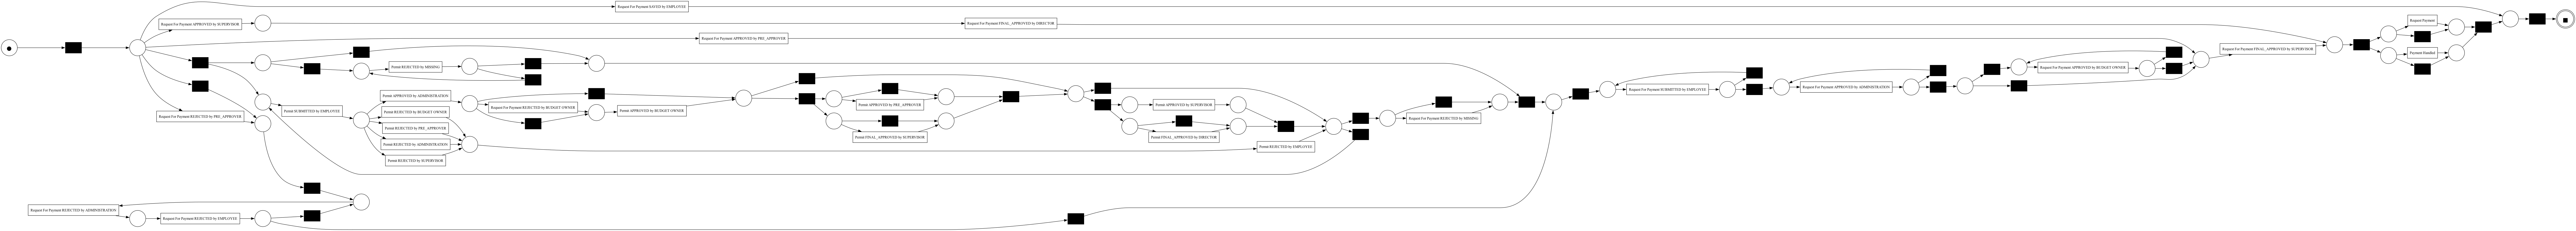

In [3]:
pm4py.view_petri_net(net, initial_marking, final_marking)

### Alignment between discovered model and log

In [4]:
def generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking):
    from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
    from pm4py.algo.conformance.alignments.petri_net import variants
    from pm4py.objects.petri_net.utils import align_utils
    max_events=0
    for trace in log:
        counter=0
        for event in trace:
            counter+=1
        if counter > max_events:
            max_events=counter
    parameters={}
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_SYNC_COST_FUNCTION] = list(map(lambda i: .1*i, range(max_events*2)))
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_TRACE_COST_FUNCTION]=list(map(lambda i: align_utils.STD_MODEL_LOG_MOVE_COST-.1*i, range(max_events*2)))
    aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking, variant=variants.state_equation_a_star, parameters=parameters)
    return aligned_traces

In [5]:
alignment_discovered_model = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/202 [00:00<?, ?it/s]

### Alignment between ground truth model and log

In [6]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/model/Model_PrepaidTravelCost.bpmn")

# 3. Convert the BPMN to a Petri net
net2, initial_marking2, final_marking2 = pm4py.convert_to_petri_net(bpmn_graph)

alignment_ground_truth = generate_alignments_adjusted_tracecost_pkl(log, net2, initial_marking2, final_marking2)

aligning log, completed variants ::   0%|          | 0/202 [00:00<?, ?it/s]

# 1. Conformance Classification

In [7]:
# Extract fitness values
alignment_ground_truth_fitness = [trace['fitness'] for trace in alignment_ground_truth]
alignment_discovered_model_fitness = [trace['fitness'] for trace in alignment_discovered_model]

# Create DataFrame
df_fitness = pd.DataFrame({
    'ground_truth_fit': alignment_ground_truth_fitness,
    'predicted_fit': alignment_discovered_model_fitness
})

In [8]:
df_fitness

,ground_truth_fit,predicted_fit
0,0.863636,0.904762
1,0.931818,0.928571
2,0.954545,0.952381
3,0.931818,0.928571
4,0.863636,0.928571
...,...,...
2094,0.931818,0.952381
2095,0.931818,0.952381
2096,0.931818,0.952381
2097,0.931818,0.952381


In [9]:
# deviating: 1
# conform: 0

df_conformance = pd.DataFrame()
df_conformance['actual'] = df_fitness['ground_truth_fit'].apply(lambda x: 1 if x < 1 else 0)
df_conformance['predicted'] = df_fitness['predicted_fit'].apply(lambda x: 1 if x < 1 else 0)

In [10]:
df_conformance

,actual,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
2094,1,1
2095,1,1
2096,1,1
2097,1,1


In [11]:
# Calculating TP, TN, FP, FN
TP = ((df_conformance['actual'] == 1) & (df_conformance['predicted'] == 1)).sum()
TN = ((df_conformance['actual'] == 0) & (df_conformance['predicted'] == 0)).sum()
FP = ((df_conformance['actual'] == 0) & (df_conformance['predicted'] == 1)).sum()
FN = ((df_conformance['actual'] == 1) & (df_conformance['predicted'] == 0)).sum()

In [12]:
precision_dev = TN / (TN + FN)
print(f"Precision Dev: {precision_dev:.2f}")

Precision Dev: 0.99


In [13]:
recall_dev = TN / (TN + FP)
print(f"Recall Dev: {recall_dev:.2f}")

Recall Dev: 0.95


In [14]:
precision_no_d = TP / (TP + FP)
print(f"Precision No Dev: {precision_no_d:.2f}")

Precision No Dev: 0.94


In [15]:
recall_no_d = TP / (TP + FN)
print(f"Recall No Dev: {recall_no_d:.3f}")

Recall No Dev: 0.986


In [16]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(df_conformance['actual'], df_conformance['predicted'])
print(f"AUC-ROC: {auc_roc:.2f}")

AUC-ROC: 0.97


# 2. Conformance Diagnostics

In [17]:
# Diagnostics only for deviating traces:

# Find indices where 'predicted' column has value 1
indices_to_keep = df_conformance[df_conformance['predicted'] == 1].index.tolist()

# Filter the lists to keep only the indices where 'predicted' is 1
alignment_discovered_model = [alignment_discovered_model[i] for i in indices_to_keep]
alignment_ground_truth = [alignment_ground_truth[i] for i in indices_to_keep]

In [18]:
# Function to extract log and model moves excluding (None, >>) and (>>, None)
def extract_moves(alignment):
    log_moves = [move for move in alignment if move[1] == '>>' and move[0] is not None]
    model_moves = [move for move in alignment if move[0] == '>>' and move[1] is not None]
    return log_moves, model_moves

# Initialize counts for moves
total_log_moves = 0
total_no_log_moves = 0
total_model_moves = 0
total_no_model_moves = 0

# Initialize counts for TP, FP, FN, TN
tp_log_moves = 0
fp_log_moves = 0
fn_log_moves = 0
tn_log_moves = 0

tp_model_moves = 0
fp_model_moves = 0
fn_model_moves = 0
tn_model_moves = 0

# Iterate through aligned traces and count moves
for i, aligned_trace in enumerate(alignment_ground_truth):
    log_moves_gt, model_moves_gt = extract_moves(aligned_trace['alignment'])
    total_log_moves += len(log_moves_gt)
    total_no_log_moves += sum(1 for move in aligned_trace['alignment'] if move[1] != '>>' or move[0] is None)
    total_model_moves += len(model_moves_gt)
    total_no_model_moves += sum(1 for move in aligned_trace['alignment'] if move[0] != '>>' or move[1] is None)
    
    if i < len(alignment_discovered_model):
        log_moves_input, model_moves_input = extract_moves(alignment_discovered_model[i]['alignment'])
        
        # Calculate TP, FP, FN, TN for log moves
        tp_log_moves += sum(1 for move in log_moves_gt if move in log_moves_input)
        fn_log_moves += sum(1 for move in log_moves_gt if move not in log_moves_input)
        fp_log_moves += sum(1 for move in log_moves_input if move not in log_moves_gt)
        tn_log_moves += sum(1 for move in aligned_trace['alignment'] if move not in log_moves_gt and move not in log_moves_input and move[1] != '>>' and move[0] != '>>')
        
        # Calculate TP, FP, FN, TN for model moves
        tp_model_moves += sum(1 for move in model_moves_gt if move in model_moves_input)
        fn_model_moves += sum(1 for move in model_moves_gt if move not in model_moves_input)
        fp_model_moves += sum(1 for move in model_moves_input if move not in model_moves_gt)
        tn_model_moves += sum(1 for move in aligned_trace['alignment'] if move not in model_moves_gt and move not in model_moves_input and move[1] != '>>' and move[0] != '>>')

# Calculate recall, precision, F1 score for log moves
recall_log_moves = tp_log_moves / (tp_log_moves + fn_log_moves) if (tp_log_moves + fn_log_moves) > 0 else 0
precision_log_moves = tp_log_moves / (tp_log_moves + fp_log_moves) if (tp_log_moves + fp_log_moves) > 0 else 0

# Calculate recall, precision, F1 score for model moves
recall_model_moves = tp_model_moves / (tp_model_moves + fn_model_moves) if (tp_model_moves + fn_model_moves) > 0 else 0
precision_model_moves = tp_model_moves / (tp_model_moves + fp_model_moves) if (tp_model_moves + fp_model_moves) > 0 else 0



# Print results for log moves
print(f"Precision (Log Moves): {precision_log_moves:.2f}")
print(f"Recall (Log Moves): {recall_log_moves:.2f}")
print("")

# Print results for model moves
print(f"Precision (Model Moves): {precision_model_moves:.2f}")
print(f"Recall (Model Moves): {recall_model_moves:.2f}")

Precision (Log Moves): 0.55
Recall (Log Moves): 0.68

Precision (Model Moves): 0.50
Recall (Model Moves): 0.36


In [19]:
# Filter the other dataframe using the indices_to_keep
df_fitness = df_fitness.loc[indices_to_keep]

In [20]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(df_fitness['ground_truth_fit'], df_fitness['predicted_fit'])

# Print the MSE restricted to 4 decimal places
print(f"The Mean Squared Error (MSE) is: {mse:.4f}")

The Mean Squared Error (MSE) is: 0.0013
